In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, replace, count, when, isnan, isnull, to_timestamp, unix_timestamp, countDistinct
from pyspark.sql.types import StructType, StructField, TimestampType
from pyspark.ml.feature import StringIndexer

spark = SparkSession.builder.appName("NYC311Calls").getOrCreate()


### Data Descriptions

#### Read Data

In [0]:
uri = "enter your path"

data = spark.read.csv(
    uri,
    header=True,
    inferSchema=True
)

#### Data Samples

In [0]:
data.show(5)

+----------+--------------------+-----------+------+--------------------+-----------------+-----------------+-------------+------------+--------------------+------------------+--------------------+------------------+---------------------+---------------------+------------+-------------------+--------+-------------+------+--------+----------------------+------------------------------+---------------+----------+--------+--------------------------+--------------------------+----------------------+------------------+------------+------------+--------------------+---------------------+-------------------+------------------------+---------+----------------------+-----------------+------------------+--------------------+---------+-------------------+------------------+----------------------+----------------+---------------+
|Unique Key|        Created Date|Closed Date|Agency|         Agency Name|   Complaint Type|       Descriptor|Location Type|Incident Zip|    Incident Address|       Street 

#### Data Schema

In [0]:
data.printSchema()

root
 |-- Unique Key: integer (nullable = true)
 |-- Created Date: string (nullable = true)
 |-- Closed Date: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- Incident Address: string (nullable = true)
 |-- Street Name: string (nullable = true)
 |-- Cross Street 1: string (nullable = true)
 |-- Cross Street 2: string (nullable = true)
 |-- Intersection Street 1: string (nullable = true)
 |-- Intersection Street 2: string (nullable = true)
 |-- Address Type: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Landmark: string (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Due Date: string (nullable = true)
 |-- Resolution Description: string (nullable = true)
 |-- Resolution Actio

#### Data Size

In [0]:
data.count()

9374581

#### Nulls Count

In [0]:
null_counts = data.select([count(when(col(c).isNull(),c)).alias(c) for c in data.columns]).collect()[0]

null_counts_dict = null_counts.asDict()

print("Null Counts in Each Column:")
for column, count in null_counts_dict.items():
    print(f"{column}: {count}")

Null Counts in Each Column:
Unique Key: 0
Created Date: 0
Closed Date: 367452
Agency: 0
Agency Name: 0
Complaint Type: 0
Descriptor: 105525
Location Type: 1207787
Incident Zip: 157722
Incident Address: 429011
Street Name: 429328
Cross Street 1: 2586873
Cross Street 2: 2587377
Intersection Street 1: 3395188
Intersection Street 2: 3390668
Address Type: 1183637
City: 508123
Landmark: 4113063
Facility Type: 8687500
Status: 0
Due Date: 9347266
Resolution Description: 427235
Resolution Action Updated Date: 141129
Community Board: 7608
BBL: 1125785
Borough: 7608
X Coordinate (State Plane): 168585
Y Coordinate (State Plane): 167463
Open Data Channel Type: 0
Park Facility Name: 0
Park Borough: 7608
Vehicle Type: 9365786
Taxi Company Borough: 9369615
Taxi Pick Up Location: 9292550
Bridge Highway Name: 9296372
Bridge Highway Direction: 9335351
Road Ramp: 9352663
Bridge Highway Segment: 9296370
Latitude: 168699
Longitude: 168699
Location: 168699
Zip Codes: 201102
Community Districts: 171525
Boroug

### Data Preprocessing

#### Fix Column Names

In [0]:
data = data.toDF(*[col.lower().replace(' ', '_') for col in data.columns])
print(data.columns)

['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name', 'complaint_type', 'descriptor', 'location_type', 'incident_zip', 'incident_address', 'street_name', 'cross_street_1', 'cross_street_2', 'intersection_street_1', 'intersection_street_2', 'address_type', 'city', 'landmark', 'facility_type', 'status', 'due_date', 'resolution_description', 'resolution_action_updated_date', 'community_board', 'bbl', 'borough', 'x_coordinate_(state_plane)', 'y_coordinate_(state_plane)', 'open_data_channel_type', 'park_facility_name', 'park_borough', 'vehicle_type', 'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name', 'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment', 'latitude', 'longitude', 'location', 'zip_codes', 'community_districts', 'borough_boundaries', 'city_council_districts', 'police_precincts', 'police_precinct']


#### Keep Useful Columns

In [0]:
keeps = ['created_date', 'closed_date', 'agency', 'complaint_type', 'location_type', 'incident_zip', 'address_type', 'city', 'status', 'community_board', 'bbl', 'borough', 'open_data_channel_type', 'latitude', 'longitude']

data = data.select(*keeps)
print(data.columns)

['created_date', 'closed_date', 'agency', 'complaint_type', 'location_type', 'incident_zip', 'address_type', 'city', 'status', 'community_board', 'bbl', 'borough', 'open_data_channel_type', 'latitude', 'longitude']


#### Keep Only Closed 311 Calls

In [0]:
data = data.where(lower(col("status")) == "closed").drop("status")

#### Drop Null Rows

In [0]:
data = data.dropna()
print(data.count())

6213236


#### Fix Data Types (DateTime)

In [0]:
dateFormat = "MM/dd/yyyy hh:mm:ss a"

data = (data.withColumn("created_date", to_timestamp(col("created_date"), dateFormat))
            .withColumn("closed_date", to_timestamp(col("closed_date"), dateFormat)))

data.printSchema()

root
 |-- created_date: timestamp (nullable = true)
 |-- closed_date: timestamp (nullable = true)
 |-- agency: string (nullable = true)
 |-- complaint_type: string (nullable = true)
 |-- location_type: string (nullable = true)
 |-- incident_zip: string (nullable = true)
 |-- address_type: string (nullable = true)
 |-- city: string (nullable = true)
 |-- status: string (nullable = true)
 |-- community_board: string (nullable = true)
 |-- bbl: long (nullable = true)
 |-- borough: string (nullable = true)
 |-- open_data_channel_type: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



#### Remove Created Date > Closed Date

In [0]:
data = data.where(col("created_date") < col("closed_date"))

### Feature Engineering

#### Add Resolution Time (Minutes)

In [0]:
data = data.withColumn("resolution_time", (unix_timestamp("closed_date") - unix_timestamp("created_date")) / 60)
data = data.drop("created_date", "closed_date")
data.select("resolution_time").show()

+------------------+
|   resolution_time|
+------------------+
|2.4166666666666665|
|              4.45|
|              3.75|
|              5.95|
|              23.0|
|25.516666666666666|
|1.7666666666666666|
|10.483333333333333|
|15.733333333333333|
|              22.7|
|1.9833333333333334|
|18.416666666666668|
|21.916666666666668|
|26.933333333333334|
| 6.566666666666666|
|              22.2|
|33.483333333333334|
|             27.85|
|1.0666666666666667|
|17.133333333333333|
+------------------+
only showing top 20 rows



In [0]:
data.printSchema()

root
 |-- agency: string (nullable = true)
 |-- complaint_type: string (nullable = true)
 |-- location_type: string (nullable = true)
 |-- incident_zip: string (nullable = true)
 |-- address_type: string (nullable = true)
 |-- city: string (nullable = true)
 |-- status: string (nullable = true)
 |-- community_board: string (nullable = true)
 |-- bbl: long (nullable = true)
 |-- borough: string (nullable = true)
 |-- open_data_channel_type: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- resolution_time: double (nullable = true)



#### Label Categorical Data 

##### Check Number of Categories

In [0]:
categories = ['agency', 'complaint_type', 'location_type', 'incident_zip', 'address_type', 'city', 'community_board', 'borough', 'open_data_channel_type']

distinct_counts = [countDistinct(col).alias(col + "_distinct_count") for col in categories]
distinct_count_df = data.select(distinct_counts)
distinct_count_df.show()

+---------------------+-----------------------------+----------------------------+---------------------------+--------------------------+---------------------------+-------------------+------------------------------+----------------------+-------------------------------------+---------------------------------+---------------------------+
|agency_distinct_count|complaint_type_distinct_count|location_type_distinct_count|incident_zip_distinct_count|street_name_distinct_count|address_type_distinct_count|city_distinct_count|community_board_distinct_count|borough_distinct_count|open_data_channel_type_distinct_count|park_facility_name_distinct_count|park_borough_distinct_count|
+---------------------+-----------------------------+----------------------------+---------------------------+--------------------------+---------------------------+-------------------+------------------------------+----------------------+-------------------------------------+---------------------------------+---------

##### Convert Categorical Features

Encode categories as labels since one hot encoding would create too many features. We can also order some categorical features based on some rules.

In [0]:
for column in categories:
    StringIndexer(inputCol=column, outputCol=column+"_label").fit(data).transform(data)

data = data.drop(categories)
data.show()

### EDA

In [0]:
import matplotlib.pyplot as plt


#### Agency Distribution

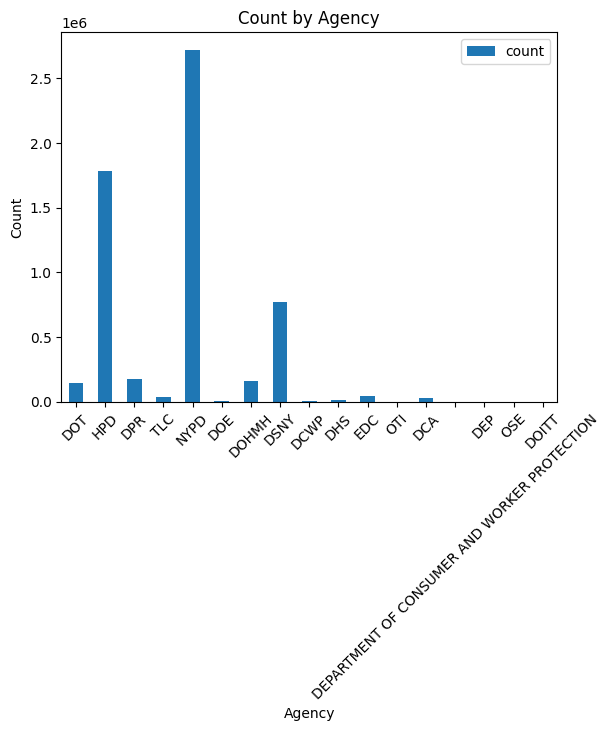

In [0]:
agencies = data.groupBy("agency").count().toPandas()

agencies.plot(kind='bar', x='agency', y='count')
plt.xlabel('Agency')
plt.ylabel('Count')
plt.title('Count by Agency')
plt.xticks(rotation=45)
plt.show()

### Main Data Preprocessing

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, replace, count, when, isnan, isnull, to_timestamp, unix_timestamp, countDistinct
from pyspark.sql.types import StructType, StructField, TimestampType
from pyspark.ml.feature import StringIndexer

spark = SparkSession.builder.appName("NYC311Calls").getOrCreate()

spark.conf.set("spark.sql.sources.commitProtocolClass", "org.apache.spark.sql.execution.datasources.SQLHadoopMapReduceCommitProtocol")
spark.conf.set("parquet.enable.summary-metadata", "false")
spark.conf.set("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false")

In [0]:
uri = "enter your path"

data = spark.read.csv(
    uri,
    header=True,
    inferSchema=True
)

#### All Data Transformations

In [0]:
keeps = ['created_date', 'closed_date', 'agency', 'complaint_type', 'location_type', 'incident_zip', 'address_type', 'city', 'status', 'community_board', 'bbl', 'borough', 'open_data_channel_type', 'latitude', 'longitude']

dateFormat = "MM/dd/yyyy hh:mm:ss a"

data = (data.toDF(*[col.lower().replace(' ', '_') for col in data.columns])
        .select(*keeps)
        .where(lower(col("status")) == "closed")
        .drop("status")
        .dropna()
        .withColumn("created_date", to_timestamp(col("created_date"), dateFormat))
        .withColumn("closed_date", to_timestamp(col("closed_date"), dateFormat))
        .where(col("created_date") < col("closed_date"))
        .withColumn("resolution_time", (unix_timestamp("closed_date") - unix_timestamp("created_date")) / 60)
        .drop("created_date", "closed_date"))

categories = ['agency', 'complaint_type', 'location_type', 'incident_zip', 'address_type', 'city', 'community_board', 'borough', 'open_data_channel_type']

for column in categories:
    data = StringIndexer(inputCol=column, outputCol=column+"_label").fit(data).transform(data)

data = data.drop(*categories)
data.show()

+----------+------------------+------------------+------------------+------------+--------------------+-------------------+------------------+------------------+----------+---------------------+-------------+----------------------------+
|       bbl|          latitude|         longitude|   resolution_time|agency_label|complaint_type_label|location_type_label|incident_zip_label|address_type_label|city_label|community_board_label|borough_label|open_data_channel_type_label|
+----------+------------------+------------------+------------------+------------+--------------------+-------------------+------------------+------------------+----------+---------------------+-------------+----------------------------+
|1008960023| 40.73251803248665|-73.98483468502799|2.4166666666666665|         0.0|                10.0|                6.0|              59.0|               0.0|       2.0|                 53.0|          3.0|                         0.0|
|3050260344| 40.65698230332589|-73.9622251496527

In [0]:
data.printSchema()

root
 |-- bbl: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- resolution_time: double (nullable = true)
 |-- agency_label: double (nullable = false)
 |-- complaint_type_label: double (nullable = false)
 |-- location_type_label: double (nullable = false)
 |-- incident_zip_label: double (nullable = false)
 |-- address_type_label: double (nullable = false)
 |-- city_label: double (nullable = false)
 |-- community_board_label: double (nullable = false)
 |-- borough_label: double (nullable = false)
 |-- open_data_channel_type_label: double (nullable = false)



#### Save Preprocessed Data for ML use

In [0]:
save_uri = "enter your path"
data.coalesce(1).write.csv(save_uri, header=True)